### 1) Kernel

Pengolahan ini menggunakan kernel ais-tt atau saat ini: pyspark3.3 ais2.8 untuk melakukan pengolahan data. Kernel ini dilengkapi dengan konfigurasi spark tambahan dan kredensial untuk Amazon Web Services (AWS).

### 2) Mengaktifkan Sesi Spark

In [ ]:
#Sedona Imports
import sedona.sql
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.core.SpatialRDD import PolygonRDD, PointRDD
from sedona.core.enums import FileDataSplitter

import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql.types as pst
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType,LongType,StringType

In [ ]:
spark = SparkSession. \
    builder. \
    appName('Emissions_Indonesia'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config('spark.jars.packages'). \
    config("spark.sql.parquet.enableVectorizedReader", "false").\
    getOrCreate()

SedonaRegistrator.registerAll(spark)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


Closing down clientserver connection


True

### 3) Read Data AIS di AWS S3 Bucket

## Gabung Ulang AIS-IHS karena 2022 ternyata difilter

In [ ]:
save_path = "s3a://ungp-ais-data-historical-backup/user_temp/"
save_path_unique = save_path + "212112081/"
save_path_unique2 = save_path + "222011485/"
data22 = spark.read.parquet(save_path_unique2 + "ais-data-indonesia-2022_expanded.parquet", header=True)

In [ ]:
# Fungsi untuk melakukan pencocokan nama kapal AIS dan IHS
import re
import math
from collections import Counter

## Fungsi untuk mendapatkan nilai Cosine
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

## Fungsi untuk mengubah text menjadi vektor sebelum menghitung nilai cosine
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

## Fungsi untuk melakukan perbandingan dua nama kapal dengan cosine similarity
def compare_vessel_name(name_1, name_2):
    vector1 = text_to_vector(name_1)
    vector2 = text_to_vector(name_2)

    cosine_result = get_cosine(vector1, vector2)
    return cosine_result

# Mengubah fungsi menjadi fungsi udf agar dapat dimanfaatkan dalam dataset pyspark
compare = F.udf(lambda x,y:compare_vessel_name(x,y),T.DoubleType())

In [ ]:
# Menghapus record duplikat
ais_data = data22.distinct()

# Ekstraksi data IHS
specs = spark.read.load("s3a://ungp-ais-data-historical-backup/register/ShipData.CSV",format="csv",sep=",",inferSchema="true",header="true")
specs = specs.withColumnRenamed("MaritimeMobileServiceIdentityMMSINumber","mmsi_ihs")\
                .withColumnRenamed("LRIMOShipNo","imo_ihs")\
                .withColumnRenamed("Draught","SummerDraught")

# Penggabungan data AIS dan IHS
## Record AIS yang Cocok Berdasaekan IMO
imo_match = ais_data\
                    .join(specs, (ais_data.imo == specs.imo_ihs),how="inner")\
                    .withColumn("matchBy", F.lit("imo"))

## Record AIS yang Tidak Cocok Berdasarkan IMO
ais_ihs_left = ais_data.join(specs, (ais_data.imo == specs.imo_ihs),how="left_anti")

## Record AIS yang Tidak Cocok Berdasarkan IMO dan cocok berdasarkan MMSI
mmsi_match = ais_ihs_left.join(specs, (ais_ihs_left.mmsi == specs.mmsi_ihs),how="inner")

## Record AIS yang Tidak Cocok Berdasarkan IMO dan cocok berdasarkan MMSI dan Nama kapal
vessel_name_check = mmsi_match.withColumn("similarity", compare(F.col("vessel_name"), F.col("ShipName")))
vessel_name_match = vessel_name_check.filter(F.col("similarity")>=0.50)\
                                        .withColumn("imo", F.col("imo_ihs"))\
                                        .withColumn("matchBy", F.lit("mmsi"))

## Penggabungan Record AIS yang cocok Berdasarkan IMO dan (MMSI dan Nama Kapal)
match_record = imo_match.union(vessel_name_match.drop(F.col("similarity")))

In [ ]:
def count_freq(dfspark):
    df = (
      dfspark
      .selectExpr(
        "*"
      )
      .withColumn("previous_freq",F.expr(f"LAG(dt_pos_utc) OVER (PARTITION BY imo ORDER BY dt_pos_utc ASC) as previous_freq"))
      .withColumn("previous_h3",F.expr(f"LAG(H3_int_index_7) OVER (PARTITION BY imo ORDER BY dt_pos_utc ASC) as previous_h3"))
      .withColumn("freq", F.expr(f"(unix_timestamp(dt_pos_utc)-unix_timestamp(previous_freq))/3600 as freq"))
      .selectExpr(
        "*"
      )
    )
    return df

In [ ]:
 data22 = count_freq(match_record)

### Union dengan residen di luar

In [ ]:
#read saved parquet
data22_resout = spark.read.parquet(save_path_unique + "ais-ihs-indonesia-2022_nonres.parquet", header=True)

In [ ]:
#kalau masih ada yang ga match
data22 = data22.drop("callsign", "ll_cat")
data22_resout = data22_resout.drop("tipe")

In [ ]:
data22 = data22.withColumnRenamed("hl_cat", "High Level Category")

In [ ]:
#union dulu
from pyspark.sql.functions import lit
data22 = data22.withColumn("tipe", lit("res nonres di dalam"))
data22_resout = data22_resout.withColumn("tipe", lit("res di luar"))

df_union_22 = data22_resout.unionByName(data22)
data = df_union_22

### 4) Install seluruh package yang akan digunakan

In [ ]:
###Packages within Kernel by default
import geopandas as gpd
import h3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib as mpl
from shapely.ops import transform
from shapely.geometry import Polygon
from datetime import datetime
import requests

import pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame

import pandas as pd
import numpy as np
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import requests

generated new fontManager


### 5) Konversi Tipe Kapal ke ISIC 501 dan Assign Residensi

Ambil data dari GitHub

In [ ]:
convert_IHS = "https://raw.githubusercontent.com/GunturFai/ais-stis/main/Activities_ISIC.csv"
convert_IHS = spark.createDataFrame(pd.read_csv(convert_IHS, delimiter=";"))
#Left Join berdasarkan ShipTypeLevel5

from pyspark.sql.functions import col
data = data.join(convert_IHS.select("ShiptypeLevel5", "Classif"), on="ShipTypeLevel5", how="left")

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


Filter data yang termasuk pada aktivitas ISIC 501 berdasarkan ShipTypeLevel5

In [ ]:
data_filtered = data.filter(col("Classif") == "ISIC 501")

In [ ]:
#Hapus OperatorCountryOfDomicileName yang NA/NULL
data_filtered = data_filtered.na.drop(subset=["OperatorCountryofDomicileName"])

Rename Residensi
1.   Jika type = "res di luar" maka variabel Residensi memiliki nilai "Residen di Luar Teritory"
2.   Jika type = "res nonres di dalam" maka ada dua hal
*   Jika OperatorCountryofDomicile = Indonesia maka variabel Residensi = "Residen di Teritori"
*   Jika OperatorCountryofDomicile = Selain Indonesia maka variabel Residensi = "Nonresiden di Teritori"



In [ ]:
data = data_filtered
from pyspark.sql.functions import when
# Menambahkan variabel Residensi berdasarkan kondisi type dan OperatorCountryofDomicile
data = data.withColumn("Residensi",
     when(col("tipe") == "res di luar", "Residen di Luar Teritory")
    .when((col("tipe") == "res nonres di dalam") & (col("OperatorCountryofDomicileName") == "Indonesia"), "Residen di Teritori")
    .when((col("tipe") == "res nonres di dalam") & (col("OperatorCountryofDomicileName") != "Indonesia"), "Nonresiden di Teritori")
)

## Koreksi akibat pengambilan data yang diperluas 1%

In [ ]:
h3_perluasan = spark.read.parquet(save_path_unique + "h3_index_level5_perluasan.parquet", header=True)

In [ ]:
#data inner
data_inner = data.filter(data['Residensi'] != 'Residen di Luar Teritory')
#Inner Join untuk mendapat data yang berada di area perluasan 1%
data_matched_inner = data_inner.join(h3_perluasan, data_inner.H3_int_index_5 == h3_perluasan.h3_index, "inner")

In [ ]:
#data_matched_inner.count()

In [ ]:
#data_matched_inner.filter(data_matched_inner['Residensi'] == 'Residen di Teritori').count()

In [ ]:
#data residen di perluasan 1% untuk tambahan residen outside
tambahan_res_out = data_matched_inner.filter(data_matched_inner['Residensi'] == 'Residen di Teritori')
tambahan_res_out = tambahan_res_out.drop('h3_index')
#data residen outside
data_resout = data.filter(data['Residensi'] == 'Residen di Luar Teritory')
#data corrected
data_residen_outside_corrected = data_resout.union(tambahan_res_out)

In [ ]:
dataunion2 = data_residen_outside_corrected

In [ ]:
cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))

imo_filter = dataunion2.groupBy("imo")\
                .agg(F.count('dt_pos_utc').alias("count_ais"),
                    cnt_cond(F.col('sog') > 3). alias("count_min_sog"))\
                .where((F.col('count_ais') < 10)|(F.col('count_min_sog') < 20))\
                .select("imo")

In [ ]:
imo_filter.printSchema()

root
 |-- imo: integer (nullable = true)



In [ ]:
imo_filter_list = imo_filter.select("imo")

In [ ]:
data_filtered = dataunion2.join(imo_filter_list, on="imo", how="left_anti")

In [ ]:
#Hapus pesan dengan durasi >4 jam
data_less4 = data_filtered.filter(F.col("freq")<4)

In [ ]:
#yang terbuang
data_more4 = data_filtered.filter(F.col("freq")>=4)
data_more4.count()

28578

## Preprocessing data IHS

In [ ]:
## mendapatkan kapal unik
data = data_less4
unique_vessel = data.dropDuplicates(["imo"])

### 1) Pengecekan Nilai Null pada variabel di IHS

Menampilkan banyaknya nilai null

### 2) Penyesuaian Spesifikasi Kapal Sesuai IMO GHG 4

In [ ]:
headers = {'User-Agent': 'XY'}

map_vessel_type = "https://raw.githubusercontent.com/nandyarz/ais/main/map_vessel_type_imo4.json"
map_vessel_type = pd.read_json(map_vessel_type)

#Types Table
vessel_type = "https://raw.githubusercontent.com/nandyarz/ais/main/type_table.json"
vessel_type = pd.read_json(vessel_type)

#####Functions--------------------
##Cleaning punctuations from new ais_types
def clean_string(text):
    text=''.join([word for word in text if word not in string.punctuation])
    text=text.lower()

    return text

##base shiptypelevel5 to comapre to
base_stype=map_vessel_type.ShiptypeLevel5.unique().tolist()

##Compare similiraty higher than 50% and return respective shiptype5 value
def compare_similarity(text):
    comp=[text]+base_stype
    cleaned=list(map(clean_string,comp))
    vectors=CountVectorizer().fit_transform(cleaned)
    vectors=vectors.toarray()
    csim=cosine_similarity(vectors)

    val_com=np.max(csim[0,1:])

    if val_com>0.75:
        v_type=base_stype[np.argmax(csim[0,1:])]
    else:
        v_type=None

    return v_type

##Imo bin finder
def bin_finder(vessel_t,value,df_in):
    try:
        bin_imo=df_in[((df_in.StandardVesselType==vessel_t)&(df_in.mindiff<=value)&(df_in.maxdiff>=value))].imo4bin.iloc[0]
    except:
        bin_imo=0
    return bin_imo

def ihs_preprocessing(df):
    columns = ['Powerkwmax', 'Speed', 'Speedmax', 'SummerDraught', 'MainEngineRPM']

    for c in columns:
        df[c].replace(0, np.nan, inplace=True)
        df[c]=df.groupby(["StandardVesselType", "imobin"])[c].apply(lambda x:x.fillna(x.mean()))
    return df

###++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
###Unit of cargo measurement per vessel type
unit={'Bulk carrier':'Deadweight',
     'Chemical tanker':'Deadweight',
     'Container':"TEU",
     'General cargo':'Deadweight',
     'Liquified gas tanker':'GrossTonnage',
     'Oil tanker':'Deadweight',
     'Other liquids tankers':'Deadweight',
     'Ferry-pax only':'GrossTonnage',
     'Cruise':'GrossTonnage',
     'Ferry-RoPax':'GrossTonnage',
     'Refrigerated bulk':'Deadweight',
     'Ro-Ro':'Deadweight',
     'Vehicle':'GrossTonnage',
     'Yacht':'GrossTonnage',
     'Service-tug':'GrossTonnage',
     'Miscellaneous-fishing':'GrossTonnage',
     'Offshore':'GrossTonnage',
     'Service-other':'GrossTonnage',
     'Miscellaneous-other':'GrossTonnage'}

##Engine type allocation
oil_eng=['Diesel-Elec & Gas Turbine(s)','Oil Engs & Fuel Cell-Electric''Oil Eng(s), Elec-Dr, Aux Sail','Oil Engines, Geared & Elec. Dr','Oil Eng(s) & Gas Turb(s) El.Dr','Oil Eng(s) Direct Dr, Aux Sail','Oil Eng(s) Dd & Gas Turb(s) El','Oil Engines, F&S, Geared Drive','Oil Engines, Direct & Elec. Dr','Oil Engines, Elec. & Direct Dr','Oil Engine(s), Drive Unknown','Oil Engines, Elec. & Geared Dr','Oil Eng(s), Geared, Aux Sail','Oil Engs & Gas Turb(s), Geared','Oil Engine(s), Electric Drive','Oil Engine(s), Direct Drive','Oil Engine(s), Geared Drive']
sail=['Sail, Aux Petrol Eng(s) D.Dr.','Sail, Aux Oil Eng(s), Elec Dr.','Sail, Aux Oil Eng(s), Geared','Sail','Sail, Aux Oil Eng(s) Direct-Dr',]
gas_tur=['Gas Turbine(s), Electric Drive','Gas Turbine(s) Or Diesel Elec.','Gas Turbine(s) & Diesel Elec.','Gas Turbine(s), Geared Drive',]
steam=['S.Turb, Gear & Oil Eng(s), Ele','St. Turb(s) Elec Dr. Or D.E.','Steam Turbine(s), Direct Drive','Steam Recip(s) With Lp Turbine','Steam Turbine(s), Elec.Drive','Steam- & Gas-Turbines, Geared','Steam Turbine(s), Geared Drive','Steam Recip(s), Direct Drive',]


def adapted_specs_imo(df_unique_imo):
    df_unique_imo.rename(columns={"vessel_type_main":"ais_type","length":"ais_loa","width":"ais_beam"},inplace=True)

    ind=df_unique_imo.copy()

    ind=ind.assign(ShiptypeLevel5=np.where(ind.ShiptypeLevel5.isnull(),ind.ais_type,ind.ShiptypeLevel5))
    ##Remove values with Shiptypelevel5 null. Not much else to do with this records.
    ##Remove nans before similarity check
    ind=ind[ind.ShiptypeLevel5.notnull()]
    ind=ind.assign(ShiptypeLevel5=np.where(ind.ShiptypeLevel5.isin(base_stype),ind.ShiptypeLevel5,
                                           ind.ShiptypeLevel5.apply(lambda x: compare_similarity(x))))
    ##Ensure no vessel without Standard vessel type
    ind=ind[ind.ShiptypeLevel5.notnull()]

    ##---Pending----Inputation here input from AIS(Length,Beam) and Shiptypelevel5 to have [DWT,GT]. Potential RF Regressor (missForest).

    ind=pd.merge(ind,map_vessel_type,how="left",on='ShiptypeLevel5')

    ind=ind.assign(imobin=ind.apply(lambda x: bin_finder(x.StandardVesselType,x[unit[x.StandardVesselType]],vessel_type),axis=1))

    ind=ihs_preprocessing(ind)

    ###Fuel allocation
    ind=ind.assign(fuel=np.where(((ind.FuelType1First=='Residual Fuel')|(ind.FuelType2Second=='Residual Fuel')),
                                np.where(((ind.PropulsionType.isin(['Steam Turbine(s), Geared Drive','S.Turb, Gear & Oil Eng(s), Ele','Steam Recip(s), Direct Drive','Steam- & Gas-Turbines, Geared','Steam Turbine(s), Elec.Drive','Steam Recip(s) With Lp Turbine','Steam Turbine(s), Direct Drive','St. Turb(s) Elec Dr. Or D.E.',]))\
                                                                &(ind.StandardVesselType=='Liquified gas tanker')),"LNG","HFO"),
                                    np.where(((ind.FuelType1First=='Distillate Fuel')&(ind.FuelType2Second=='Distillate Fuel')),"MDO",
                                    np.where(((ind.FuelType1First=='Distillate Fuel')&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),"MDO",
                                    np.where(((ind.FuelType1First.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))&(ind.FuelType2Second=='Distillate Fuel')),"MDO",
                                    np.where(((ind.FuelType1First=='Coal')&(ind.FuelType2Second=='Distillate Fuel')),"MDO",
                                    np.where(((ind.FuelType1First=='Methanol')&(ind.FuelType2Second=='Distillate Fuel')),'Methanol',
                                        np.where((((ind.FuelType1First=='Residual Fuel')|(ind.FuelType2Second=='Residual Fuel'))&\
                                                ((ind.StandardVesselType=='Liquified gas tanker')&(ind.PropulsionType.isin(['Steam Turbine(s), Geared Drive','S.Turb, Gear & Oil Eng(s), Ele','Steam Recip(s), Direct Drive','Steam- & Gas-Turbines, Geared','Steam Turbine(s), Elec.Drive','Steam Recip(s) With Lp Turbine','Steam Turbine(s), Direct Drive','St. Turb(s) Elec Dr. Or D.E.',])))),'LNG',
                                        np.where(((ind.FuelType1First=='Gas Boil Off')&(ind.FuelType2Second=='Distillate Fuel')),'LNG',
                                        np.where(((ind.FuelType1First.isin(["LNG",'Lpg','Lng']))&(ind.FuelType2Second=='Distillate Fuel')),'LNG',
                                        np.where(((ind.FuelType1First.isin(["LNG",'Lpg','Lng']))&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),'LNG',
                                        np.where(((ind.FuelType1First.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))&(ind.FuelType2Second.isin(["LNG",'Lpg','Lng']))),'LNG',
                                        np.where(ind.FuelType2Second=='Gas Boil Off','LNG',
                                            np.where(((ind.FuelType1First=='Nuclear')&(ind.FuelType2Second=='Distillate Fuel')),'Nuclear',
                                            np.where(((ind.FuelType1First=='Nuclear')&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),'Nuclear',
                                                    np.where(((ind.FuelType1First=='Coal')&(ind.FuelType2Second.isin(['Yes, But Type Not Known','Not Applicable','Unknown',None]))),'Coal',
                                                            np.where(ind.FuelType1First=='Methanol','Methanol',
                                None))))))))))))))))
                )


    ###Engine types
    ind=ind.assign(meType=np.where(ind.PropulsionType.isin(oil_eng),
                                np.where(ind.MainEngineRPM<=300,"SSD",
                                np.where(ind.MainEngineRPM.between(301,900),"MSD",
                                np.where(ind.MainEngineRPM>900,"HSD","SSD"))),
                        np.where(ind.PropulsionType.isin(['Petrol Engine(s), Direct Drive','Petrol Engine(s), Geared Drive']),"HSD",
                        np.where(ind.PropulsionType.isin(sail),"Sail",
                        np.where(ind.PropulsionType=='Battery-Electric',"Batteries",
                        np.where(ind.PropulsionType=='Non-Propelled','Non-Propelled',
                        "SSD"))))))

    ind=ind.assign(meType=np.where(ind.fuel=="LNG",
                                np.where(((ind.MainEngineModel.str.contains("X"))|(ind.MainEngineModel.str.contains("DF"))),"LNG-Otto-SS",
                                np.where(ind.MainEngineRPM>300,"LNG-Otto-MS",
                                np.where(ind.MainEngineModel.str.contains("ME"),"LNG-Diesel","LNG-Otto-MS"
                                ))),
                            np.where(ind.fuel=="Methanol","Methanol",
                                ind.meType)))


    ##Gas turbines and Steam turbines conditional on former filters
    ind=ind.assign(meType=np.where(((ind.PropulsionType.isin(gas_tur))|(((ind.meType.isin(["SSD","MSD"]))&(ind.fuel=="Gas")))),"Gas Turbine",
                        np.where(ind.PropulsionType.isin(steam),"Steam Turbine",
                        ind.meType
                    ))
                )
    ind=ind.assign(fuel=np.where(ind.meType=="Sail","Sail",
                        np.where(ind.meType=="Non-Propelled","Non-Propelled",
                        np.where(((ind.fuel.isnull())&(ind.meType=="HSD")),"MDO",
                        np.where(((ind.fuel.isnull())&(ind.meType=="MSD")),"MDO",
                        np.where(((ind.fuel.isnull())&(ind.meType=="SSD")),"HFO",
                                ind.fuel)))))
                )

    ind=ind[['imo','mmsi', 'vessel_name', 'GrossTonnage', 'Deadweight', 'LengthOverallLOA',
    'DateOfBuild', 'TEU', 'Powerkwmax', 'MainEngineModel', 'Speed', 'Speedmax', 'Speedservice', 'BreadthExtreme', 'SummerDraught', 'FuelType1Capacity',
    'FuelType2Capacity', 'LightDisplacementTonnage', 'MainEngineRPM', 'MainEngineType', 'Powerkwservice', 'PropulsionType',
    'TotalBunkerCapacity', 'StandardVesselType', 'imobin', 'fuel', 'meType','ais_beam','ais_loa']]

    return ind

In [ ]:
specs = spark.createDataFrame(adapted_specs_imo(unique_vessel.toPandas()))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, 

In [ ]:
columns = ['Powerkwmax', 'Speed', 'Speedmax', 'SummerDraught', 'MainEngineRPM']

specs.select([F.count(F.when((F.col(c)==0)|(F.col(c).isNull()), c)).alias(c) for c in columns]).show(vertical=True)

-RECORD 0------------
 Powerkwmax    | 0   
 Speed         | 0   
 Speedmax      | 0   
 SummerDraught | 0   
 MainEngineRPM | 0   



### 3) Penggabungan Data AIS dan Spesifikasi IHS

In [ ]:
df = data.select("imo","draught","sog","dt_pos_utc","freq","longitude","latitude").join(specs,["imo"], how="inner")

### 4) Pengisian nilai null dan default pada data AIS: draught dan sog

In [ ]:
# Fungsi untuk mengisi nilai null dan default
def infill(dfspark):
    w1 = Window.partitionBy('imo').orderBy('dt_pos_utc')
    w2 = w1.rowsBetween(0, Window.unboundedFollowing)

    dfspark = dfspark.withColumn("dt_pos_utc_unix", F.unix_timestamp(F.col("dt_pos_utc")))
    dfspark = dfspark.withColumn("dt_pos_utc_null", F.when(F.col("draught")==0, None).otherwise(F.col("dt_pos_utc_unix"))) \
                        .withColumn("draught_null", F.when(F.col("draught")==0, None).otherwise(F.col("draught")))
    dfspark = dfspark.withColumn("dt_pos_utc_diff", (F.lit(2)*F.col("dt_pos_utc_unix")-F.last('dt_pos_utc_null',True).over(w1)-F.first('dt_pos_utc_null',True).over(w2)))

    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("dt_pos_utc_diff")<=0, F.last('draught_null',True).over(w1)).otherwise(F.first('draught_null',True).over(w2)))
    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill").isNull(), F.first('draught_null',True).over(w2)).otherwise(F.col("draught_fill")))

    w1 = Window.partitionBy(["StandardVesselType", "imobin"])
    w2 = Window.partitionBy()

    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill").isNull(), F.avg("draught_null").over(w1)).otherwise(F.col("draught_fill")))
    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill").isNull(), F.avg("draught_null").over(w2)).otherwise(F.col("draught_fill")))
    dfspark = dfspark.withColumn("draught_fill", F.when(F.col("draught_fill") > F.lit(1.5)*F.col("SummerDraught"), F.col("SummerDraught")).otherwise(F.col("draught_fill")))\
                        .withColumn("sog", F.when(F.col("sog") > F.col("SpeedMax"), F.col("SpeedMax")).otherwise(F.col("sog")))

    return dfspark.drop("dt_pos_utc_unix", "dt_pos_utc_null", "dt_pos_utc_diff", "draught_mean")

In [ ]:
# Menerapkan fungsi infill dan menghitung load = sog/Speed
df = infill(df).withColumn("load",F.col("sog")/F.col("Speed"))

### 6) Penentuan Fase Operasional

In [ ]:
# conditional rule pada fase operasional
def op_phase_assign(df):

    anch="Anchorage"
    berth="Berth"
    slow="Slow transit"
    normal="Normal cruising"
    man="Manoeuvring"

    df = df.withColumn("op_phase",
                      F.when(F.col("sog")<=1, berth).otherwise(
                      F.when(((F.col("sog")>1)&(F.col("sog")<=3)), anch).otherwise(
                      F.when(((F.col("sog")>3)&(F.col("sog")<=5)), man).otherwise(
                      F.when(((F.col("sog")>5)&(F.col("load")<=0.65)), slow).otherwise(
                      normal)
                      ))))


    return df

In [ ]:
# Menerapkan fungsi conditional rule
df = op_phase_assign(df)

# ESTIMASI POWER DEMAND

### AE AND AB

In [ ]:
ae_ab_power = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/01-ae_ab_power.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
df = df.withColumn("ae_power",F.when(F.col("Powerkwmax")<=150,0)
                                    .otherwise(F.when(F.col("Powerkwmax").between(151,500),F.lit(0.05)*F.col("Powerkwmax")*F.col("freq"))))\
        .withColumn("ab_power",F.when(F.col("Powerkwmax")<=150,0))

In [ ]:
df = df.join(ae_ab_power,["StandardVesselType","imobin"],"left")

In [ ]:
df = df.withColumn("ae_power",F.when(F.col("ae_power").isNull(),
                                                           F.when(F.col("op_phase").isin(["Slow transit","Normal cruising"]),F.col("ae_sea")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Berth",F.col("ae_berth")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Manoeuvring",F.col("ae_man")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Anchorage",F.col("ae_anch")*F.col("freq"))\
                                                           .otherwise(F.col("ae_sea")*F.col("freq"))))))\
                                           .otherwise(F.col("ae_power")))\
                                .withColumn("ab_power",F.when(F.col("ab_power").isNull(),
                                                           F.when(F.col("op_phase").isin(["Slow transit","Normal cruising"]),F.col("ab_sea")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Berth",F.col("ab_berth")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Manoeuvring",F.col("ab_man")*F.col("freq"))\
                                                           .otherwise(F.when(F.col("op_phase")=="Anchorage",F.col("ab_anch")*F.col("freq"))\
                                                           .otherwise(F.col("ab_sea")*F.col("freq"))))))\
                                           .otherwise(F.col("ab_power")))

### ME

In [ ]:
weath_foul = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/11-correction_factor.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
df = df.join(weath_foul,["StandardVesselType","imobin"],"left")

df = df.withColumn("me_power",F.when(F.col("op_phase").isin(["Berth","Anchorage"]),0)\
                                           .otherwise(F.when(F.col("StandardVesselType")=="Cruise",
                                                      (F.lit(0.70)*F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling")))\
                                                      .otherwise(F.when(F.col("StandardVesselType")=="Container",
                                                                        F.when(F.col("imobin").isin([8,9]),
                                                                               (F.lit(0.75)*F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling")))\
                                                                        .otherwise((F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling"))))\
                                                                 .otherwise((F.col("Powerkwmax")*((F.col("draught")/F.col("SummerDraught"))**0.66)*F.col("load")**3)/(F.col("weather")*F.col("fouling")))
                                                                )))
df = df.withColumn("me_power",F.col("me_power")*F.col("freq"))


# ESTIMASI FUEL CONSUMPTION

### SFOC ME

In [ ]:
me_sf = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/03-SFC_base.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
df = df.join(me_sf,["meType","fuel"],"left")

##Creates a column with Year of Build as an integer variable
df = df.withColumn("YearOfBuild",F.col("DateOfBuild").cast(StringType()).substr(1,4).cast(IntegerType()))

df = df.withColumn("sfc_me",F.when(F.col("meType").isin(["SSD","MSD","HSD"]),
                                                  F.when(F.col("YearOfBuild")<=1983,F.col("_83")*(F.lit(0.455)*(F.col("load")**2)-F.lit(0.710)*F.col("load")+F.lit(1.280)))\
                                                  .otherwise(F.when(F.col("YearOfBuild").between(1984,2000),F.col("84_2000")*(F.lit(0.455)*(F.col("load")**2)-F.lit(0.710)*F.col("load")+F.lit(1.280)))\
                                                  .otherwise(F.when(F.col("YearOfBuild")>=2001,F.col("2001_")*(F.lit(0.455)*(F.col("load")**2)-F.lit(0.710)*F.col("load")+F.lit(1.280)))\
                                                            )))\
                                           .otherwise(F.when(F.col("YearOfBuild")<=1983,F.col("_83"))\
                                           .otherwise(F.when(F.col("YearOfBuild").between(1984,2000),F.col("84_2000"))\
                                           .otherwise(F.when(F.col("YearOfBuild")>=2001,F.col("2001_"))))))

### SFOC AE AND AB

In [ ]:
ae_ab_sf = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/04-SFC_base_AE.csv"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
ae_sf = ae_ab_sf.filter(F.col("meType")=="AB").drop("meType")
ab_sf = ae_ab_sf.filter(F.col("meType")=="AE").drop("meType")

In [ ]:
##AE
df = df.join(ae_sf,["fuel"],how="left")

df = df.withColumn("sfc_ae",F.when(F.col("YearOfBuild")<=1983,F.col("ae_ab_83"))\
                                           .otherwise(F.when(F.col("YearOfBuild").between(1984,2000), F.col("ae_ab_84_2000"))\
                                           .otherwise(F.when(F.col("YearOfBuild")>=2001, F.col("ae_ab_2001_"))\
                                           .otherwise(F.lit(0)))))


df = df.drop(*("ae_ab_83","ae_ab_84_2000","ae_ab_2001_"))

##AB
df = df.join(ab_sf,["fuel"],how="left")

df = df.withColumn("sfc_ab",F.when(F.col("YearOfBuild")<=1983,F.col("ae_ab_83"))\
                                           .otherwise(F.when(F.col("YearOfBuild").between(1984,2000), F.col("ae_ab_84_2000"))\
                                           .otherwise(F.when(F.col("YearOfBuild")>=2001, F.col("ae_ab_2001_"))\
                                           .otherwise(F.lit(0)))))

### FC

In [ ]:
df = df.withColumn("me_con",F.col("me_power")*F.col("sfc_me"))\
                               .withColumn("ae_con",F.col("ae_power")*F.col("sfc_ae"))\
                               .withColumn("ab_con",F.col("ab_power")*F.col("sfc_ab"))\
                               .withColumn("pilot_con",F.col("me_power")*F.col("pilot_mdo"))  ###Pilot MDO for LNG fuel

# ESTIMASI EMISI

## FUEL BASED

### CO2

In [ ]:
df = df.withColumn("pilot_con",F.when(F.col("pilot_con").isNull()|F.isnan(F.col("pilot_con")),0).otherwise(F.col("pilot_con")))
ef_co2 = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/21-EF_carbon.csv"))

df = df.join(ef_co2,["fuel"],"left")

df = df.withColumn("co2_g",F.col("me_con")*F.col("ef_co2")+\
                                            F.col("ae_con")*F.col("ef_co2")+\
                                            F.col("ab_con")*F.col("ef_co2")+\
                                            F.col("pilot_con")*F.lit(3.206))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


## ENERGY BASED

### CH4

In [ ]:
ef_ch4 = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/22-EF_methana.csv"))
ef_ch4_ae = ef_ch4.filter(F.col("meType")=="AE").drop("meType").withColumnRenamed("ef_ch4","ef_ch4_ae")
ef_ch4_ab = ef_ch4.filter(F.col("meType")=="AB").drop("meType").withColumnRenamed("ef_ch4","ef_ch4_ab")

df = df.join(ef_ch4,["meType","fuel"],"left")\
        .join(ef_ch4_ae,["fuel"],"left")\
        .join(ef_ch4_ab,["fuel"],"left")

##Low load factor
df = df.withColumn("ef_ch4",F.when(F.col("load")<0.02,F.lit(21.18))\
                                           .otherwise(F.when(F.col("load").between(0.02,0.1),2.18)\
                                           .otherwise(F.when(F.col("load").between(0.1001,0.2),1.0).otherwise(F.col("ef_ch4")))))


df = df.withColumn("ch4_g",F.col("me_power")*F.col("ef_ch4")+\
                                           F.col("ae_power")*F.col("ef_ch4_ae")+\
                                           F.col("ab_power")*F.col("ef_ch4_ab"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


### NO2

In [ ]:
ef_n2o = spark.createDataFrame(pd.read_csv("https://raw.githubusercontent.com/nandyarz/ais/main/table/23-EF_nitrous_oxide.csv"))
ef_n2o_ae = ef_n2o.filter(F.col("meType")=="AE").drop("meType").withColumnRenamed("ef_n2o","ef_n2o_ae")
ef_n2o_ab = ef_n2o.filter(F.col("meType")=="AB").drop("meType").withColumnRenamed("ef_n2o","ef_n2o_ab")

df = df.join(ef_n2o,["meType","fuel"],"left")\
                                .join(ef_n2o_ae,["fuel"],"left")\
                                .join(ef_n2o_ab,["fuel"],"left")

##Low load factor
df = df.withColumn("ef_n2o",F.when(F.col("load")<0.02,F.lit(4.63))\
                                           .otherwise(F.when(F.col("load").between(0.02,0.1),F.lit(1.22))\
                                           .otherwise(F.when(F.col("load").between(0.1001,0.2),1.0).otherwise(F.col("ef_n2o")))))

df = df.withColumn("n2o_g",F.col("me_power")*F.col("ef_n2o")+\
                                           F.col("ae_power")*F.col("ef_n2o_ae")+\
                                           F.col("ab_power")*F.col("ef_n2o_ab"))

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [ ]:
##Transform grams to tonnes
df=df.withColumn("co2_t",F.col("co2_g")*1e-6)\
        .withColumn("ch4_t",F.col("ch4_g")*1e-6)\
        .withColumn("n2o_t",F.col("n2o_g")*1e-6)

# VISUALISASI DAN RINGKASAN HASIL ESTIMASI

## Emission per ship type

In [ ]:
vessel_co2_ship=df.filter(~((F.isnan(F.col("co2_t")))|(F.col("co2_t").isNull()))).groupBy("StandardVesselType").agg({"co2_t":"sum"}).orderBy("sum(co2_t)",ascending=False)
vessel_ch4_ship=df.filter(~((F.isnan(F.col("ch4_t")))|(F.col("ch4_t").isNull()))).groupBy("StandardVesselType").agg({"ch4_t":"sum"}).orderBy("sum(ch4_t)",ascending=False)
vessel_n2o_ship=df.filter(~((F.isnan(F.col("n2o_t")))|(F.col("n2o_t").isNull()))).groupBy("StandardVesselType").agg({"n2o_t":"sum"}).orderBy("sum(n2o_t)",ascending=False)

In [ ]:
vessel_co2_ship.show(19)

+--------------------+------------------+
|  StandardVesselType|        sum(co2_t)|
+--------------------+------------------+
|        Bulk carrier| 899764.2032935675|
|          Oil tanker| 764669.3333000757|
|Liquified gas tanker| 503331.0951589732|
|     Chemical tanker|395238.84208098205|
|           Container|193816.86610597983|
|               Ro-Ro| 66617.04894928954|
|       General cargo|22508.449652706608|
|      Ferry-pax only|14702.273395080958|
| Miscellaneous-other|10948.076927752296|
|   Refrigerated bulk|1293.6438530364878|
|             Vehicle| 93.08079756192447|
+--------------------+------------------+



In [ ]:
vessel_ch4_ship.show(19)

+--------------------+--------------------+
|  StandardVesselType|          sum(ch4_t)|
+--------------------+--------------------+
|Liquified gas tanker|   145.5901817151733|
|        Bulk carrier|  14.704976068987282|
|          Oil tanker|    8.82082949346591|
|     Chemical tanker|   4.684251347569423|
|           Container|   2.721243216778397|
|               Ro-Ro|  0.9483947690914629|
|       General cargo|  0.2711753270032007|
|      Ferry-pax only| 0.20290860505702749|
| Miscellaneous-other|0.013063925390989871|
|   Refrigerated bulk|0.011413197202157636|
|             Vehicle|0.001248511271648...|
|Miscellaneous-fis...|5.266661347222221E-5|
+--------------------+--------------------+



In [ ]:
vessel_n2o_ship.show(19)

+--------------------+--------------------+
|  StandardVesselType|          sum(n2o_t)|
+--------------------+--------------------+
|        Bulk carrier|   48.12919158539622|
|          Oil tanker|   41.83118075555645|
|Liquified gas tanker|  27.323998016341736|
|     Chemical tanker|   20.61527409883633|
|           Container|   9.619436833887445|
|               Ro-Ro|  3.2433858658050854|
|       General cargo|  1.0375469171262994|
|      Ferry-pax only|  0.6625165976585203|
|   Refrigerated bulk|0.052318634921777976|
| Miscellaneous-other|0.044590969462698915|
|             Vehicle|0.004316302889331...|
|Miscellaneous-fis...|1.895998084999999...|
+--------------------+--------------------+



## Heatmap per emission

In [ ]:
geo_to_h3 = F.udf(lambda latitude, longitude, resolution: h3.string_to_h3(h3.geo_to_h3(latitude,longitude, resolution)), LongType())

df_emission = df.withColumn("H3_int_index_6",geo_to_h3(F.col('latitude'),F.col("longitude"),F.lit(6)))\
                            .withColumn("totalEm", F.col("co2_t") + 21 * F.col("ch4_t") + 310 * F.col("n2o_t"))
df_plot = df_emission.groupby("H3_int_index_6").agg({"totalEm": "sum"}) \
    .withColumn("log_totalEmission", F.log10(F.col("sum(totalEm)")))
df_plot = df_plot.toPandas()

In [ ]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 772601 entries, 0 to 772600
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   H3_int_index_6     772601 non-null  int64  
 1   sum(totalEm)       755638 non-null  float64
 2   log_totalEmission  755593 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 17.7 MB


### Emisi Residen Nonteritori

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import Normalize

# NORMALIZE berdasarkan seluruh nilai log_totalEmission (termasuk yang <= 0)
vmin = df_plot['log_totalEmission'].min()
vmax = df_plot['log_totalEmission'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = mpl.cm.jet

df_filtered = df_plot[df_plot['log_totalEmission'] > 0.4]

Text(0.5, 1008.1667205555556, '')

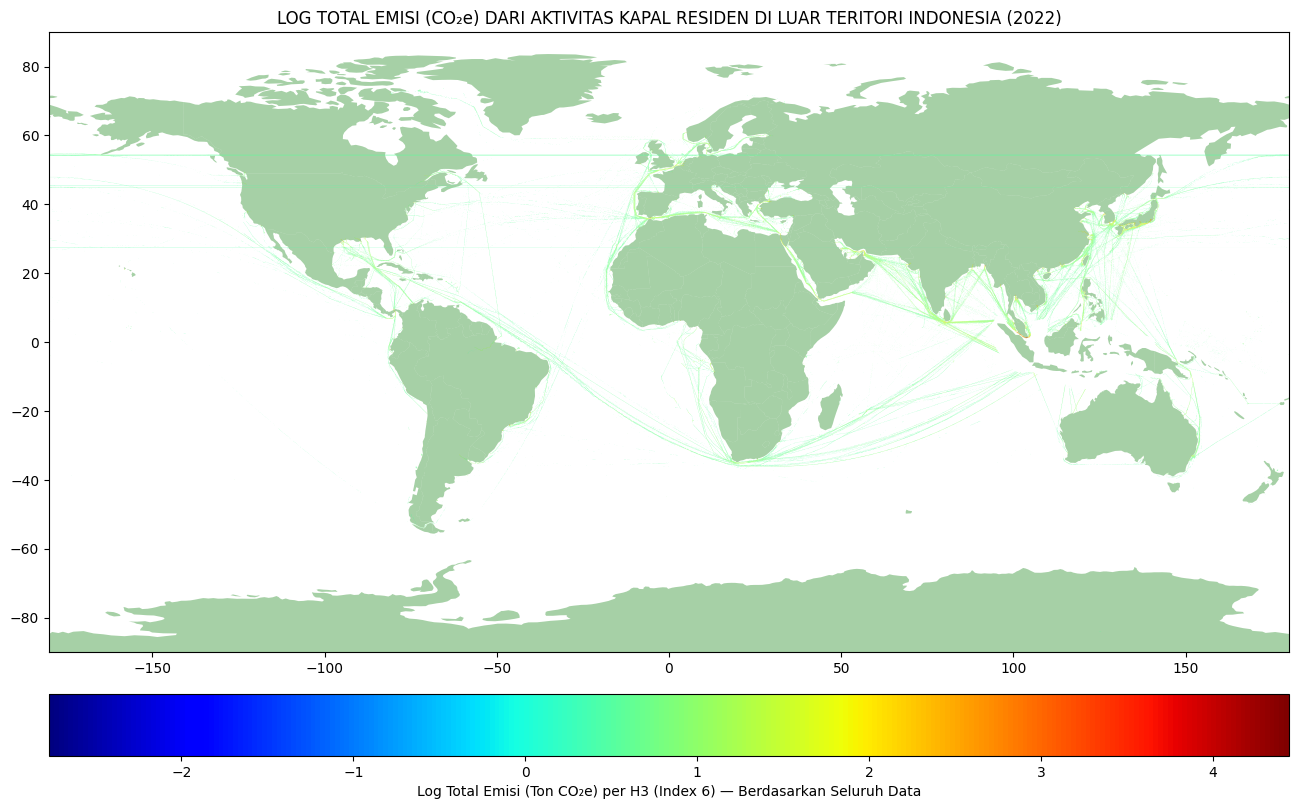

In [ ]:
fig, ax = plt.subplots(figsize=(16, 27))

# Plot latar belakang peta negara
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(ax=ax, alpha=0.4, color="forestgreen")

# Plot hanya data dengan emisi > 0, tapi gunakan colormap dari semua data
colors = cmap(norm(df_filtered['log_totalEmission']))
df_filtered.plot(ax=ax, color=colors)

# Tambahkan colorbar manual
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Hack: kosongkan data dummy
cbar = plt.colorbar(sm, ax=ax, orientation="horizontal", fraction=0.03, pad=0.02)
cbar.set_label("Log Total Emisi (Ton CO₂e) per H3 (Index 6) — Berdasarkan Seluruh Data")

# Atur tampilan peta
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_title("LOG TOTAL EMISI (CO₂e) DARI AKTIVITAS KAPAL RESIDEN DI LUAR TERITORI INDONESIA (2022)")
ax.set_xlabel("")

## Emission per Month and Per Resident Type only on ISIC 501

In [ ]:
##Transform grams to tonnes
df = df.withColumn("date_pos",F.to_date("dt_pos_utc"))

df = df.where(df.date_pos > "2021-12-31")
df = df.withColumn('month_pos', F.month(df['date_pos']))

In [ ]:
vessel_co2=df.select("month_pos", "co2_t")\
                .filter(~((F.isnan(F.col("co2_t")))|(F.col("co2_t").isNull())))\
                .groupby("month_pos")\
                .agg({"co2_t":"sum"})

vessel_ch4=df.select("month_pos", "ch4_t")\
                .filter(~((F.isnan(F.col("ch4_t")))|(F.col("ch4_t").isNull())))\
                .groupby("month_pos")\
                .agg({"ch4_t":"sum"})

vessel_n2o=df.select("month_pos", "n2o_t")\
                .filter(~((F.isnan(F.col("n2o_t")))|(F.col("n2o_t").isNull())))\
                .groupBy("month_pos")\
                .agg({"n2o_t":"sum"})

In [ ]:
vessel_co2.show(12)

+---------+------------------+
|month_pos|        sum(co2_t)|
+---------+------------------+
|       12|212648.51385809403|
|        1| 229272.8920029323|
|        6|244730.52315058405|
|        3|246182.34646312858|
|        5| 262968.8436380964|
|        9|239957.64398546325|
|        4|244909.32274293917|
|        8|256339.78376790514|
|        7|252215.55205554608|
|       10|238133.19593173306|
|       11|220621.98701417694|
|        2|225002.34402294856|
+---------+------------------+



In [ ]:
vessel_ch4.show(12)

+---------+------------------+
|month_pos|        sum(ch4_t)|
+---------+------------------+
|       12| 11.98537694981006|
|        1|15.928201440446136|
|        6|13.366092700302097|
|        3|13.942692999114636|
|        5|15.258939372397856|
|        9|  16.7740103157399|
|        4|17.215394519896552|
|        8|16.471237181076315|
|        7| 17.16269438078257|
|       10|11.449687688219361|
|       11| 16.61244326495048|
|        2| 11.80296725288852|
+---------+------------------+



In [ ]:
vessel_n2o.show(12)

+---------+------------------+
|month_pos|        sum(n2o_t)|
+---------+------------------+
|       12| 11.31845529020519|
|        1| 12.25153884185001|
|        6|13.046058476626657|
|        3|13.127429192966888|
|        5|14.079266827188773|
|        9|12.784228070362587|
|        4| 13.07214203316806|
|        8|13.631690917367141|
|        7|12.909932747623696|
|       10|12.623346083046341|
|       11|11.763916209616614|
|        2|11.955934077645358|
+---------+------------------+



In [ ]:
#jumlah kapal
vessel_count = df.select("month_pos", "imo") \
    .filter(F.col("imo").isNotNull()) \
    .groupBy("month_pos") \
    .agg(F.countDistinct("imo").alias("unique_vessels"))

In [ ]:
vessel_count.show(12)

+---------+--------------+
|month_pos|unique_vessels|
+---------+--------------+
|       12|           408|
|        1|           404|
|        6|           411|
|        3|           403|
|        5|           394|
|        9|           419|
|        4|           410|
|        8|           440|
|        7|           429|
|       10|           426|
|       11|           412|
|        2|           395|
+---------+--------------+



### Stop Sesi Spark

In [ ]:
spark.stop()